In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import datetime
from math import sqrt, floor
import numpy as np
import pandas as pd

In [47]:
track = pd.read_xml('track2.gpx', xpath='//*[local-name()="trkpt"]', namespaces = {"_": "http://www.topografix.com/GPX/1/1"})
track = track.rename(columns={'time': 'time_raw'})
track['time'] = pd.to_datetime(track['time_raw'], format="%Y-%m-%dT%H:%M:%S.%fZ", errors='coerce')
mask = track['time'].isnull()
track.loc[mask, 'time'] = pd.to_datetime(track['time_raw'], format="%Y-%m-%dT%H:%M:%SZ", errors='coerce')

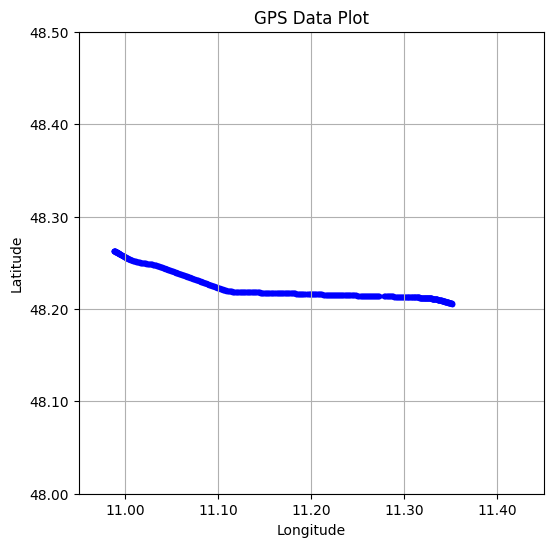

In [107]:
# Plotting the GPS data
plt.figure(figsize=(6, 6))
plt.scatter(track['lon'], track['lat'], c='blue', marker='.', label='GPS Data')
plt.grid(True)
#plt.axis('off')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GPS Data Plot')
plt.xlim(10.95, 11.45)  # Specify the range for the x-axis
plt.ylim(48.0, 48.50)      # Specify the range for the y-axis
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Display two decimal places for x-axis
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Display two decimal places for y-axis

#plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [49]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth specified in decimal degrees.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of the Earth in kilometers
    radius_earth = 6371.0
    
    # Calculate the distance
    distance = radius_earth * c
    return distance

def get_track_details(longitudes, latitudes, timestamps):                                                                       
    """                                                                                                                 
    Source: https://www.tjansson.dk/2021/03/vectorized-gps-distance-speed-calculation-for-pandas/
    Calculates the instantaneous speed from the GPS positions and timestamps. The distances between the points          
    are calculated using a vectorized haversine calculation the great circle distance between two arrays of points on   
    the earth (specified in decimal degrees). All args must be of equal length.                                         
 
    Args:                                                                                                               
        longitudes: pandas series of longitudes                                                                         
        latitudes:  pandas series of latitudes                                                                          
        timestamps: pandas series of timestamps                                                                         
 
    Returns:                                                                                                            
        Speed is returned an array in km/h.                                                                             
 
    Example:                                                                                                            
        >>> df['gpsSpeed'] = gps_speed(df.longitude, df.latitude, df.recordedAt)
    """                                                                                                                 
 
    assert longitudes.shape[0] > 1
    assert latitudes.shape[0] > 1
    assert timestamps.shape[0] > 1
 
    lon1 = longitudes.values[:-1]
    lat1 = latitudes.values[:-1]
    lon2 = longitudes.values[1:]
    lat2 = latitudes.values[1:]
 
    # Vectorized haversine calculation
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    a = np.sin((lat2 - lat1) / 2.0)**2 + (np.cos(lat1) * np.cos(lat2) * np.sin((lon2 - lon1) / 2.0)**2)
    m_array = 6371 * 1000 * 2 * np.arcsin(np.sqrt(a))
    time_array = (timestamps.diff().dt.total_seconds()).values[1:]
 
    # Calculate the speed
    time_array[time_array == 0] = np.nan  # To avoid division by zero
    speed = m_array / time_array
 
    # Make the array as long as the input arrays
    speed = np.insert(speed, 0, np.nan, axis=0)
    m_array = np.insert(m_array, 0, np.nan, axis=0)
    time_array = np.insert(time_array, 0, np.nan, axis=0)
    
    # bearing
    delta_lon = lon2 - lon1

    y = np.sin(delta_lon) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon)

    bearing = (np.degrees(np.arctan2(y, x)) + 360) % 360
    bearing = np.insert(bearing, 0, np.nan, axis=0)
    # Make the array as long as the input arrays
    
    #return [speed, np.cumsum(km_array * 1000), (bearing + 360) % 360, bearing_rad, np.cos(bearing_rad), np.sin(bearing_rad), km_array * 1000, time_array * 3600]
    return [speed, m_array, np.cumsum(pd.DataFrame(m_array)), time_array, np.cumsum(pd.DataFrame(time_array)), bearing]

In [50]:
#track['speed'], track['distance'], track['heading'], track['heading_rad'], track['heading_x'], track['heading_y'], track['ds'], track['dt'] = get_track_details(track['lon'], track['lat'], track['time'])
track['speed_ms'], track['ds'], track['distance'], track['dt'], track['triptime'], track['bearing'] = get_track_details(track['lon'], track['lat'], track['time'])
track['speed_kmh'] = track['speed_ms'] * 3.6

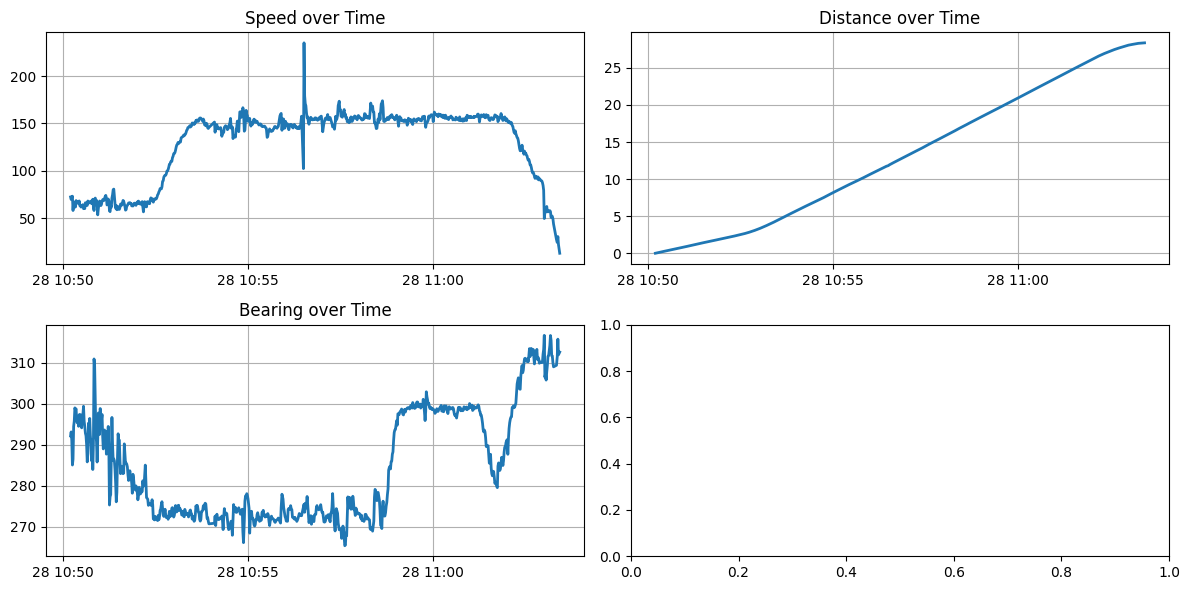

In [122]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6), tight_layout=False)
axs[0][0].set_title("Speed over Time");
axs[0][0].grid(True);
axs[0][0].plot(track['time'], track['speed_kmh'], linewidth=2, linestyle='-');

axs[0][1].set_title("Distance over Time");
axs[0][1].grid(True);
axs[0][1].plot(track['time'], track['distance'] / 1000., linewidth=2, linestyle='-');

axs[1][0].set_title("Bearing over Time");
axs[1][0].grid(True);
axs[1][0].plot(track['time'], track['bearing'], linewidth=2, linestyle='-');

(48.2, 48.3)

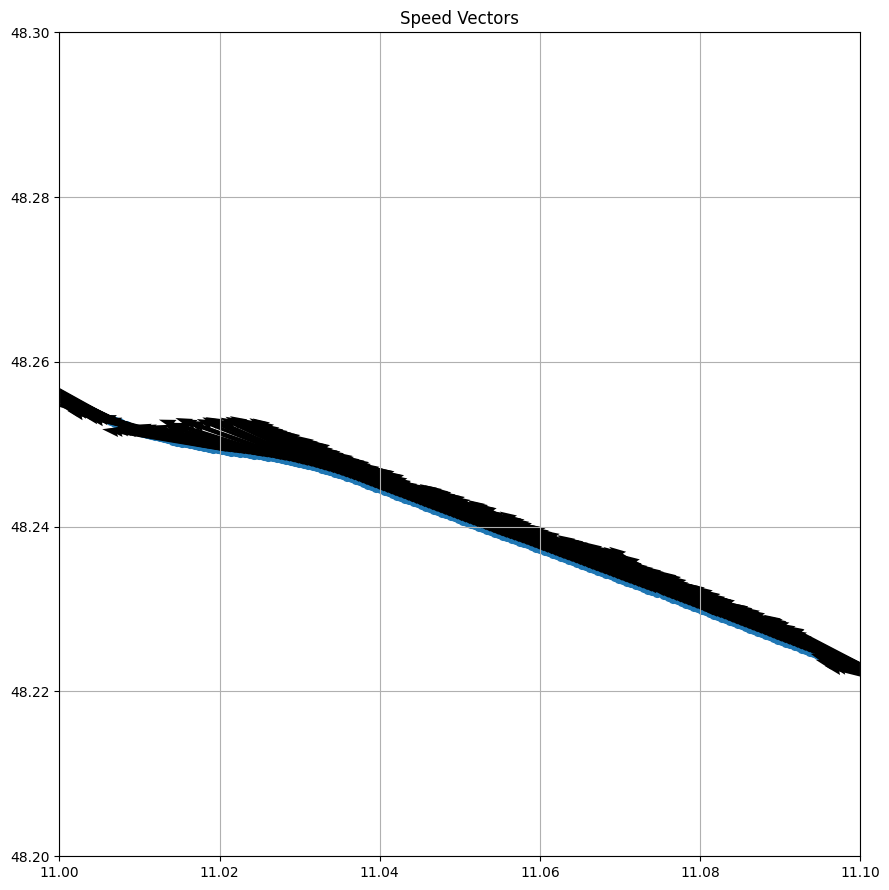

In [121]:
fig, axs = plt.subplots(1, 1, figsize=(9, 9), tight_layout=False)
heading_rad = -np.radians(track['bearing'] - 90)
x_component = track['speed_kmh'] * np.cos(heading_rad)
y_component = track['speed_kmh'] * np.sin(heading_rad)
axs.set_title("Speed Vectors");
axs.grid(True);
n = 500
m = 700
axs.scatter(track['lon'][n:m], track['lat'][n:m], linewidth=2, linestyle='-');
axs.quiver(track['lon'][n:m], track['lat'][n:m], x_component[n:m], y_component[n:m], scale=1000)
plt.xlim(11.0, 11.1)  # Specify the range for the x-axis
plt.ylim(48.2, 48.3)      # Specify the range for the y-axis